# SOFM网络

## 简介

SOFM网络是对哺乳动物大脑皮层神经的侧抑制以及自组织特性的模型，其基本要点如下：

1. 相近输入应当被映射到相近的区域
2. 网络对输入的相应不是非0即1的，而是以一个神经元为中心，形成一个从中心到四周逐渐减弱的相应区域
3. 在2的基础上，对于中心周围的区域是正反馈，对于较远距离的区域则是负反馈

在SOFM中，通过计算输入与各神经元之间的欧氏距离，将欧氏距离最小的作为输出（响应最大）

学习阶段则依照上述的要点2、3实现对参数的学习。

## 符号定义

|符号|含义|
|:-:|:-:|
|$\bm{X}$|输入向量|
|n|输入维度|
|q|二维SOFM网络的分辨率|
|$P_{ij}$|坐标为(i, j)的神经元|
|$\bm{W_{ij}}$|坐标为(i, j)的神经元的权重向量|
|$\bm{\hat{y}}$|预测输出|
|$\bm{y}$|真实输出|

## 正向计算

$$
\begin{equation}
    \bm{\hat{y}} = \argmin(d(\bm{X}, \bm{W_{11}}), d(\bm{X}, \bm{W_{12}}), \cdots, d(\bm{X}, \bm{W_{qq}}))
\end{equation}
$$

## 参数学习

1. 输入训练样本$\bm{X}$并计算得到预测输出$\bm{\hat{y}}$
2. 以$\bm{\hat{y}}$为中心调整权重
$$
\begin{equation}
    \begin{array}{cc}
    \bm{W_{ij}}(t+1) = \bm{W_{ij}}(t) + \alpha(t)_{ij}(\bm{X}-\bm{W_{ij}}(t+1)) \\ \\
    \alpha(t)_{ij} = \mu\frac{1}{\sigma(t)}exp(-\frac{||P_{\bm{\hat{y}}}-P_{ij}||^2_2}{2\sigma(t)^2})
    \end{array}
\end{equation}
$$
3. 迭代特定的步数后结束运行

In [1]:
import os
import imageio
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class SOFM(object):

    def __init__(self, input_dim, network_resolution):

        self.input_dim = input_dim
        self.network_resolution = network_resolution

        np.random.seed(1024)
        self.weight = np.random.random((self.network_resolution, self.network_resolution, self.input_dim))
    
    def forward(self, input_vector):
        output_matrix = self.weight - np.tile(input_vector, (self.network_resolution, self.network_resolution, 1))

        output_vector = np.unravel_index(np.argmin(np.linalg.norm(output_matrix, axis=2), axis=None), (self.network_resolution, self.network_resolution))

        return output_vector
    
    def fit(self, train_samples, lr=0.4, iterations=10000):

        x_matrix, y_matrix = np.meshgrid(np.arange(self.network_resolution), np.arange(self.network_resolution))
        # network_matrix = np.concatenate((np.expand_dims(x_matrix, axis=2), np.expand_dims(y_matrix, axis=2)), axis=2)
        
        # for train_sample in train_samples:
        sigma_ = 8

        fig_count = 1
        print_frequency = 1
        
        plt.figure(figsize=(12, 10))
        for iter in range(iterations):

            sample_index = np.random.randint(len(train_samples))
            train_sample = train_samples[sample_index]

            pred_coord = self.forward(train_sample)
            # 计算距离
            distance_matrix = np.power(x_matrix-pred_coord[1], 2) + np.power(y_matrix-pred_coord[0], 2)

            # 计算更新权重
            alpha_ = np.zeros((self.network_resolution, self.network_resolution, self.input_dim))
            alpha_basic = lr * np.exp(-distance_matrix/(2 * sigma_**2))
            for i in range(self.input_dim):
                alpha_[:, :, i] = alpha_basic

            # 更新权重
            self.weight += alpha_ * (np.tile(train_sample, (self.network_resolution, self.network_resolution, 1)) - self.weight)

            if iter % (iterations//20) == 0:
                sigma_ *= 0.6
                sigma_ = max(sigma_, 0.3)
                lr *= 0.9
                # print(sigma_, mask_distance)

            if iter % print_frequency == 0:
                self.draw_func(train_samples, fig_count, iter, train_sample)

                fig_count += 1
                print_frequency = int(pow(1.1, fig_count))

    def draw_func(self, train_samples, count, iter, train_sample=None, if_show=False):
        # 输出权重矩阵
        plt.cla()
        plt.clf()
        plt.title("SOFM & iter:{}".format(iter), fontsize=20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)

        plt.scatter(train_samples[:, 0], train_samples[:, 1], c="#ffa400", label="train sample")
        if train_sample is not None:
            plt.scatter([train_sample[0]], [train_sample[1]], c="#ff2121", label="current sample")

        for i in range(network_resolution):
            plt.plot(self.weight[i, :, 0], self.weight[i, :, 1], c="#4c8dae", label="SOFM Network", linewidth=2)
            plt.plot(self.weight[:, i, 0], self.weight[:, i, 1], c="#4c8dae", label="SOFM Network", linewidth=2)
            plt.scatter(self.weight[i, :, 0], self.weight[i, :, 1], c="#b36d61", label="SOFM node", s=100)

        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys(), fontsize=15, bbox_to_anchor=(1.01, 1))
        plt.tight_layout()
        plt.savefig("./images/temp/{}.png".format(count), dpi=100)
        if if_show:
            plt.show()

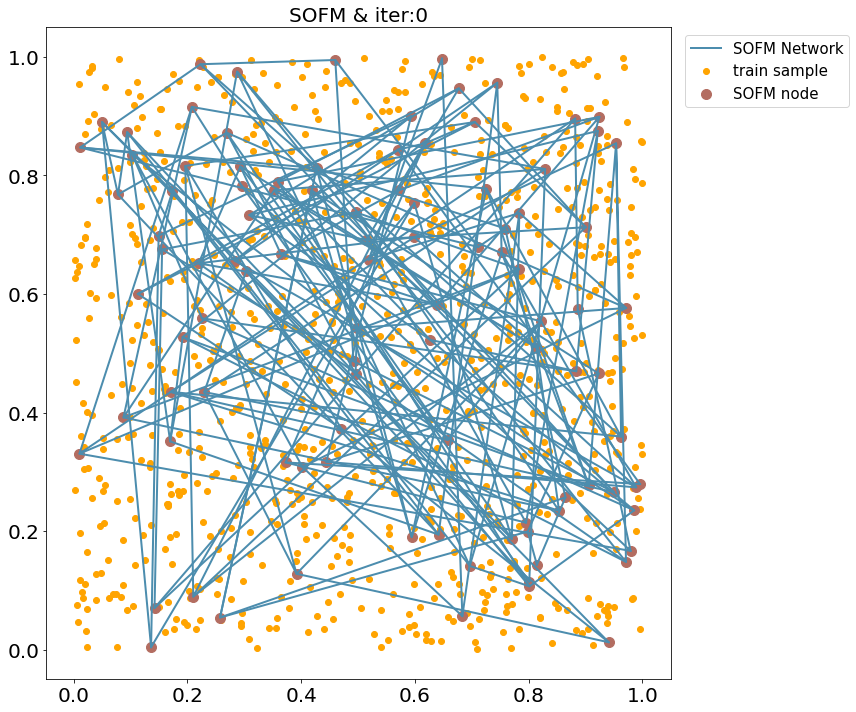

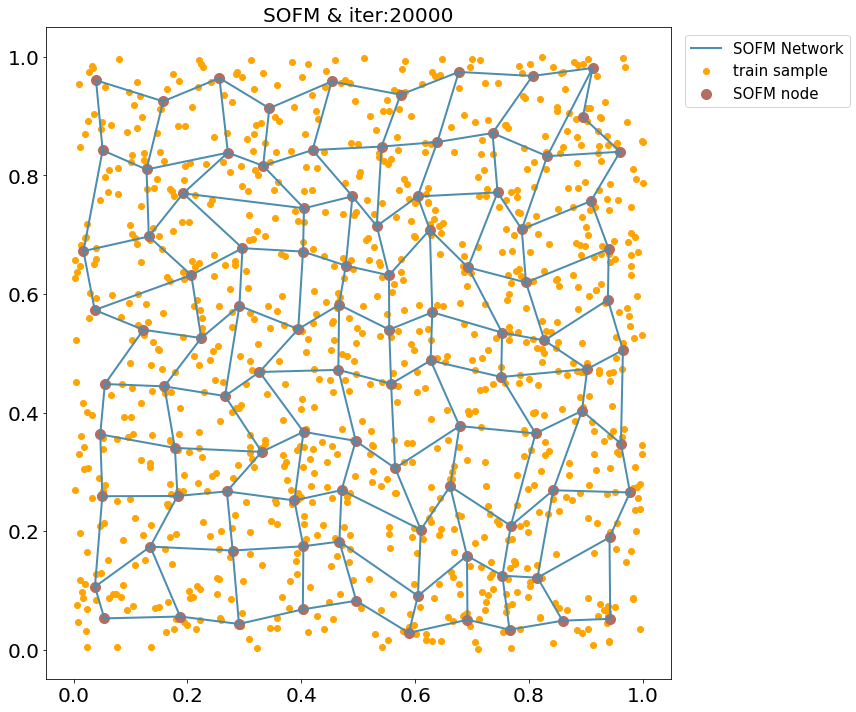

In [3]:
# 测试数据

# 输入维度为2
# 二维SOFM分辨率为10
# 总迭代步数100000
input_dim = 2
network_resolution = 10
max_iteration = 20000

sofm = SOFM(input_dim=input_dim, network_resolution=network_resolution)

# 学习
# 从1~10中任意采样
np.random.seed(1024)
samples_list = np.random.random((1000, input_dim))

# 输出图像
plt.figure(figsize=(12, 10))
sofm.draw_func(samples_list, 0, 0, if_show=True)

sofm.fit(samples_list, iterations=max_iteration)

sofm.draw_func(samples_list, 0, max_iteration, if_show=True)
with imageio.get_writer("./images/{}.gif".format("SOFM_example_1"), mode="I", fps=5) as Writer:
    for ind in range(len(os.listdir("./images/temp"))):
        image = imageio.imread("./images/temp/{}.png".format(ind))
        os.remove("./images/temp/{}.png".format(ind))
        Writer.append_data(image)

## 训练过程

![保序映射](https://raw.githubusercontent.com/koolo233/NeuralNetworks/main/images/SOFM_example_1.gif "segment")

## 测试二

对于具有明显分类特征的数据进行识别

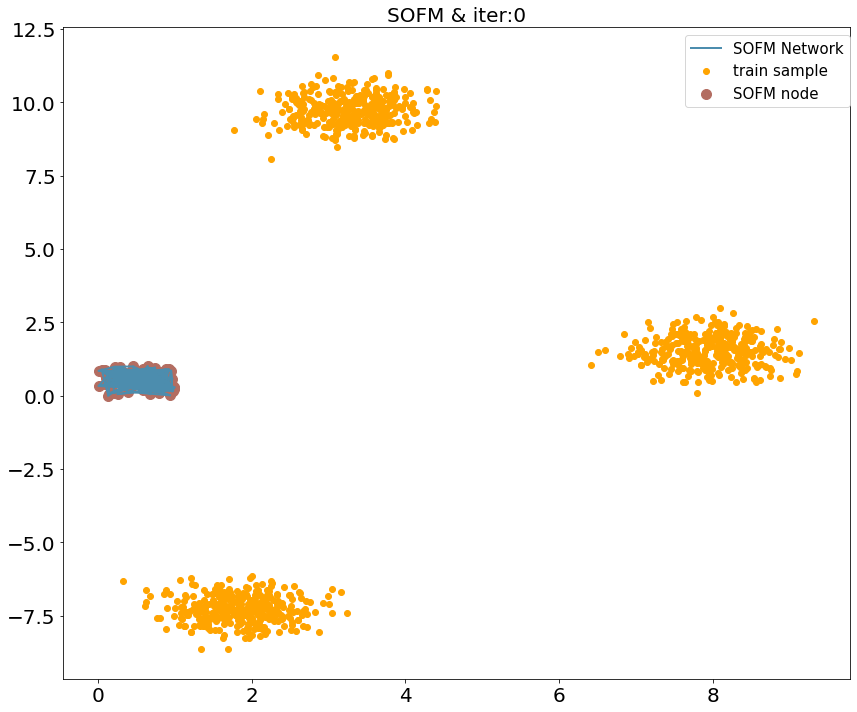

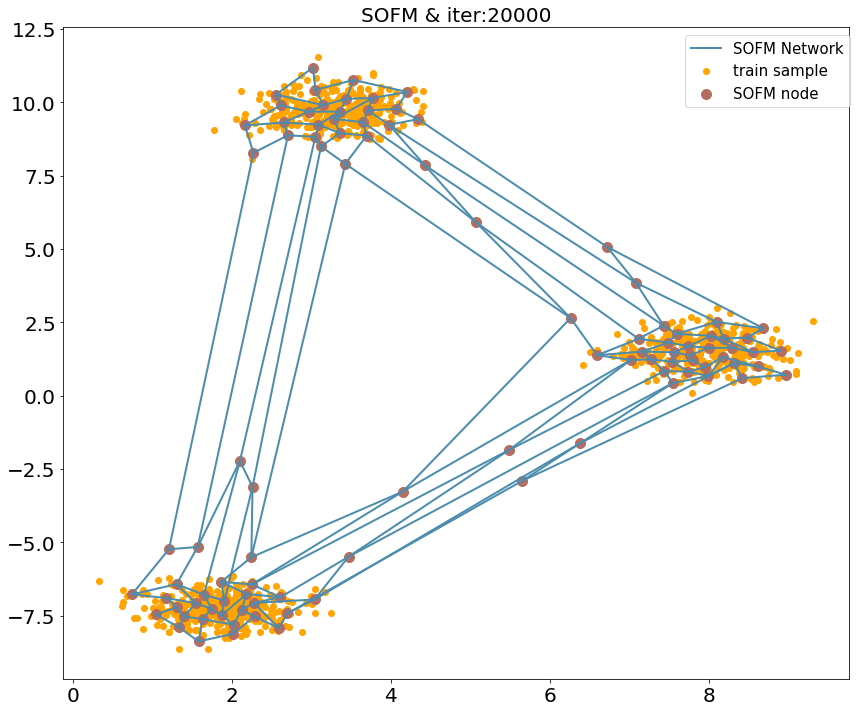

In [4]:
from sklearn.datasets import make_blobs

input_dim = 2
network_resolution = 10
max_iteration = 20000

# 生成1000个数据点，共3类
samples_list, y_list = make_blobs(n_samples=1000, centers=3, cluster_std=0.5, random_state=2048)

sofm = SOFM(input_dim=input_dim, network_resolution=network_resolution)

# 输出图像
plt.figure(figsize=(12, 10))
sofm.draw_func(samples_list, 0, 0, if_show=True)

sofm.fit(samples_list, iterations=max_iteration)

sofm.draw_func(samples_list, 0, max_iteration, if_show=True)
with imageio.get_writer("./images/{}.gif".format("SOFM_example_2"), mode="I", fps=5) as Writer:
    for ind in range(len(os.listdir("./images/temp"))):
        image = imageio.imread("./images/temp/{}.png".format(ind))
        os.remove("./images/temp/{}.png".format(ind))
        Writer.append_data(image)

训练过程

![聚类](https://raw.githubusercontent.com/koolo233/NeuralNetworks/main/images/SOFM_example_2.gif "segment")